# Importing necessary libraries

In [1]:
import os, sys, copy, helper, warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import cv2
import csv


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, utils
from torchvision.utils import make_grid

import imageio
from sklearn.metrics import confusion_matrix
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [2]:
def show_images(dataloader): 
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
        break

def accuracy(output, target):
    output = torch.exp(output)
    top_p,top_class = output.topk(1,dim = 1)
    equals = top_class == target.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [3]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [4]:
!nvidia-smi

/bin/bash: /home/sysadm/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Jun 26 00:44:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GV100        On   | 00000000:2D:00.0  On |                  Off |
| 33%   45C    P0    25W / 250W |    405MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--

# Setting necessary paths

In [5]:
path = '/home/sysadm/Documents/3ml_kkm/env/chest_xray'
train_dir = path + '/train'
test_dir = path + '/test'

# Creating dataframe with data stats

In [6]:
n_train = []
n_test = []
classes = ['PNEUMONIA', 'NORMAL']
for c in classes:
    train_images = os.listdir(train_dir + '/' + c)
    n_train.append(len(train_images))
    test_images = os.listdir(test_dir + '/' + c)
    n_test.append(len(test_images))
  

In [7]:
print(n_train)
print(n_test)

[3884, 1349]
[390, 235]


In [8]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train,
                      'Test' : n_test})
print(data)

     Classes  Train  Test
0  PNEUMONIA   3884   390
1     NORMAL   1349   235



# Visualising data stats

In [9]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Train')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Training data',fontsize=15);

In [10]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Test')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Test data',fontsize=15);

# Creating dataframe from images and labels


In [11]:
# train set

ptrain = []
ctrain = []
for folder_name in classes:
    for files in os.listdir(train_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = train_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptrain.append(path)
            ctrain.append(clss)


# test set

ptest = []
ctest = []
for folder_name in classes:
    for files in os.listdir(test_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = test_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptest.append(path)
            ctest.append(clss)

In [12]:
train_df = pd.DataFrame({'Path':ptrain,'Class':ctrain})
test_df = pd.DataFrame({'Path':ptest,'Class':ctest})
train_df.head(10)


,Path,Class
0,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
1,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
2,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
3,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
4,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
5,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
6,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
7,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
8,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
9,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA


# Data to csv

In [13]:
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

# Defining transformations for data augumentation

In [14]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ]) 

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                      ])

# Creating Custom Dataloader

In [15]:
class PneumoniaDataset():
    def __init__(self,df,labels,transform=True):
        self.df = df
        self.labels=list(df.iloc[:,1])
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.loc[idx]
        img_file, img_class = row['Path'], row['Class']
        img = Image.open(img_file).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img,img_class

In [16]:
class_dict = {'NORMAL':0, 'PNEUMONIA':1}
train_data = PneumoniaDataset(train_df,class_dict,transform = train_transforms)
test_data = PneumoniaDataset(test_df,class_dict,transform = test_transforms)

# verifying the dataloader

print(len(train_data))
next(iter(train_data))

5232


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'PNEUMONIA')

In [17]:
print(len(test_data))
next(iter(test_data))

624


(tensor([[[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020,

# Splitting training data into training and validation sets

In [18]:
# training indices to be used for validation
num_train = len(train_data); print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [19]:
# defining samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [20]:
# loading the data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 30, shuffle = True)
next(iter(train_loader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
         

# Visualising the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


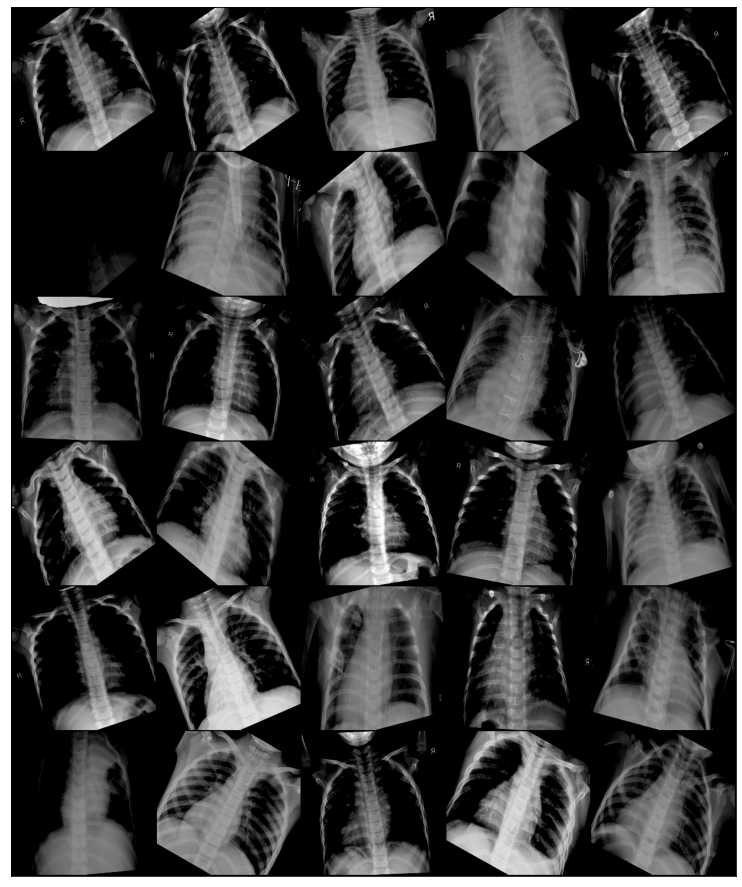

In [21]:
show_images(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


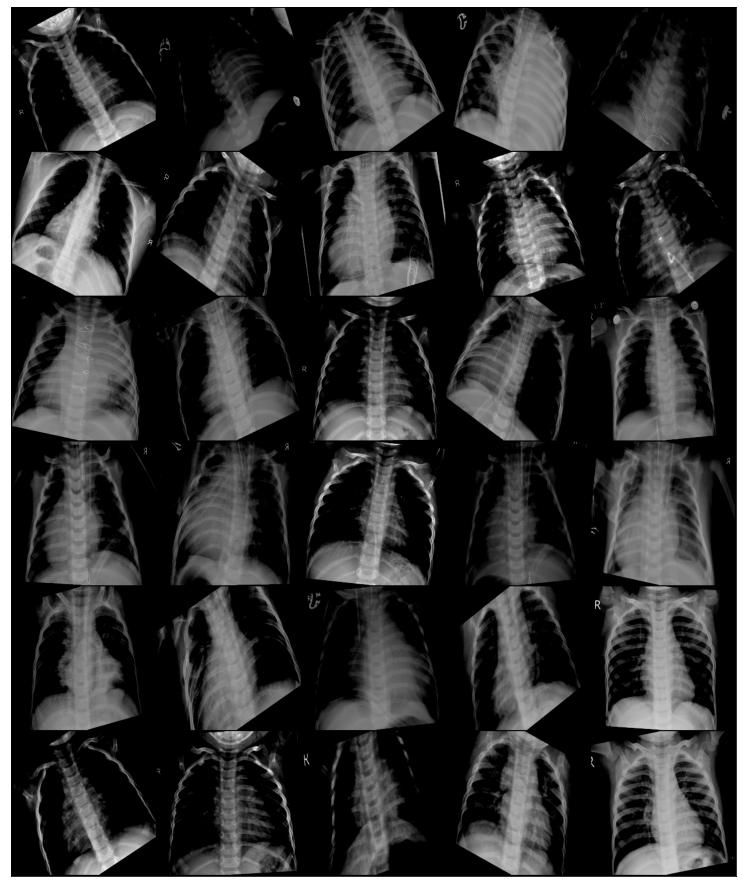

In [22]:
show_images(valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


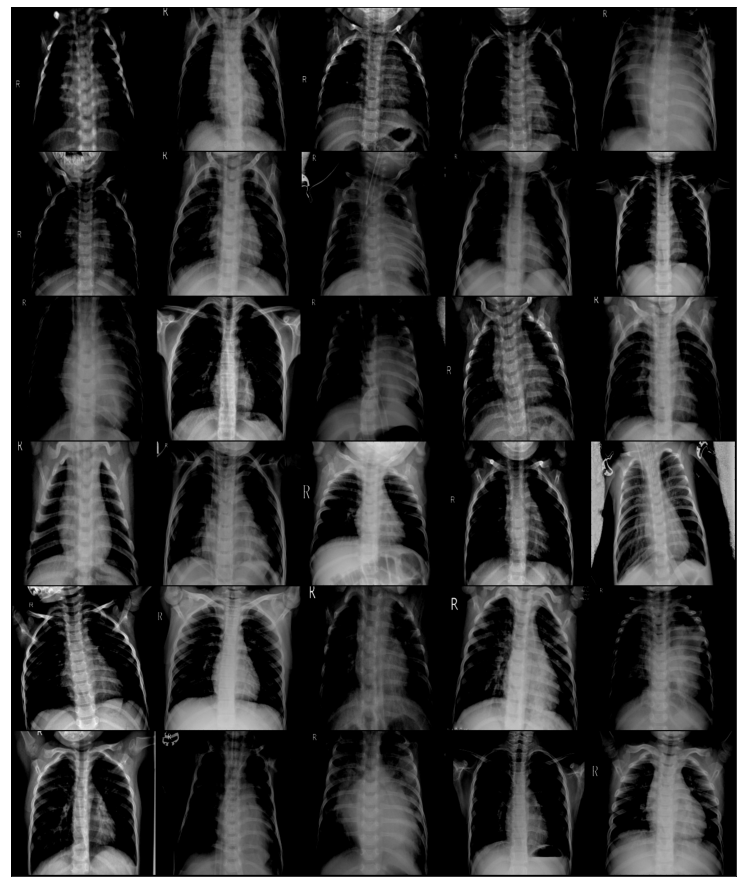

In [23]:
show_images(test_loader)

# Using Transfer Learning

##ResNet50 backbone

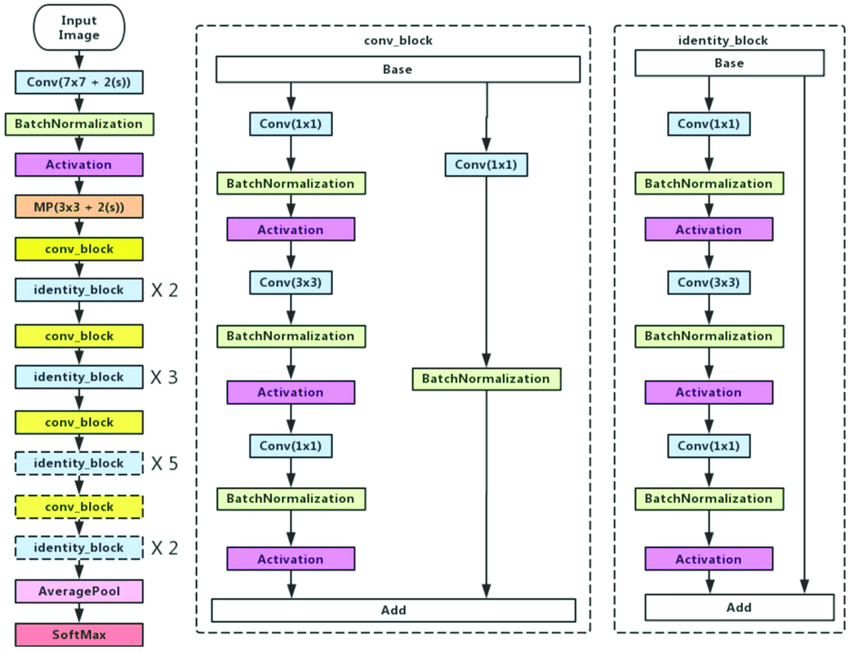

## Defining transformations according to ResNet50 standards

In [24]:
train_transforms_res = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                       ]) 

test_transforms_res = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                      ])

In [25]:
train_data_res = datasets.ImageFolder(train_dir, transform = train_transforms_res)
test_data_res = datasets.ImageFolder(test_dir, transform = test_transforms_res)

# Splitting training data into training and validation sets

In [26]:
# training indices to be used for validation

num_train_res = len(train_data_res); print(num_train_res)
indices = list(range(num_train_res))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train_res)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [27]:
# defining samplers for obtaining training and validation batches

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [28]:
# loading the data 

train_loader = torch.utils.data.DataLoader(train_data_res, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data_res, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data_res, batch_size = 30, shuffle = True)
next(iter(test_loader))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

In [29]:
# show_images(test_loader)

# Loading pretrained ResNet50 model and adding final layers

In [30]:
res_model = models.resnet50(pretrained=True)
print(res_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
# Freezing training for all "features" layers
for param in res_model.parameters():
    param.requires_grad = False

In [32]:
# Adding final layers
res_model.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Dropout(0.4),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1)) 

In [33]:
# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(res_model.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    res_model.cuda()

print(res_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


# Training and validating the model


In [34]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(1, n_epochs+1), desc = 'Model Train/Epoch: '):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    res_model.train()
    for data, target in tqdm(train_loader, desc = 'Model Train: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = res_model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: computing gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    res_model.eval()
    for data, target in tqdm(valid_loader, desc = 'Model Validation: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = res_model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(res_model.state_dict(), './../models/res_model_pneumonia.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 5.267414 	Validation Loss: 8.272557 
		Training Accuracy: 0.929554 	Validation Accuracy: 0.876557
Validation loss decreased (inf --> 8.272557).  Saving model ...



Epoch: 2 	Training Loss: 4.216000 	Validation Loss: 3.138964 
		Training Accuracy: 0.945239 	Validation Accuracy: 0.965421
Validation loss decreased (8.272557 --> 3.138964).  Saving model ...



Epoch: 3 	Training Loss: 3.827904 	Validation Loss: 3.139565 
		Training Accuracy: 0.948364 	Validation Accuracy: 0.963809



Epoch: 4 	Training Loss: 3.716928 	Validation Loss: 3.028576 
		Training Accuracy: 0.951221 	Validation Accuracy: 0.958095
Validation loss decreased (3.138964 --> 3.028576).  Saving model ...



Epoch: 5 	Training Loss: 3.476744 	Validation Loss: 3.188573 
		Training Accuracy: 0.958572 	Validation Accuracy: 0.962857



Epoch: 6 	Training Loss: 3.456405 	Validation Loss: 3.293195 
		Training Accuracy: 0.952887 	Validation Accuracy: 0.955238



Epoch: 7 	Training Loss: 3.751738 	Validation Loss: 3.177658 
		Training Accuracy: 0.950030 	Validation Accuracy: 0.961905



Epoch: 8 	Training Loss: 3.813007 	Validation Loss: 3.257214 
		Training Accuracy: 0.949346 	Validation Accuracy: 0.956190



Epoch: 9 	Training Loss: 3.951220 	Validation Loss: 3.688938 
		Training Accuracy: 0.949852 	Validation Accuracy: 0.955238



Epoch: 10 	Training Loss: 3.318306 	Validation Loss: 3.063408 
		Training Accuracy: 0.954316 	Validation Accuracy: 0.957802



Epoch: 11 	Training Loss: 3.727015 	Validation Loss: 2.919435 
		Training Accuracy: 0.952381 	Validation Accuracy: 0.962711
Validation loss decreased (3.028576 --> 2.919435).  Saving model ...



Epoch: 12 	Training Loss: 3.628543 	Validation Loss: 3.111703 
		Training Accuracy: 0.954792 	Validation Accuracy: 0.963663



Epoch: 13 	Training Loss: 3.461464 	Validation Loss: 3.101892 
		Training Accuracy: 0.954822 	Validation Accuracy: 0.957802



Epoch: 14 	Training Loss: 3.613075 	Validation Loss: 2.984222 
		Training Accuracy: 0.949792 	Validation Accuracy: 0.960000



Epoch: 15 	Training Loss: 3.576562 	Validation Loss: 3.369627 
		Training Accuracy: 0.953602 	Validation Accuracy: 0.956044



Epoch: 16 	Training Loss: 3.588676 	Validation Loss: 2.876214 
		Training Accuracy: 0.950030 	Validation Accuracy: 0.966374
Validation loss decreased (2.919435 --> 2.876214).  Saving model ...



Epoch: 17 	Training Loss: 3.518557 	Validation Loss: 3.046593 
		Training Accuracy: 0.955238 	Validation Accuracy: 0.964615



Epoch: 18 	Training Loss: 3.587804 	Validation Loss: 3.320162 
		Training Accuracy: 0.952143 	Validation Accuracy: 0.956044



Epoch: 19 	Training Loss: 3.860876 	Validation Loss: 2.907617 
		Training Accuracy: 0.949643 	Validation Accuracy: 0.967472



Epoch: 20 	Training Loss: 3.722792 	Validation Loss: 3.213570 
		Training Accuracy: 0.951727 	Validation Accuracy: 0.960806



Epoch: 21 	Training Loss: 3.581770 	Validation Loss: 3.163038 
		Training Accuracy: 0.952203 	Validation Accuracy: 0.964615



Epoch: 22 	Training Loss: 3.138567 	Validation Loss: 3.116656 
		Training Accuracy: 0.960715 	Validation Accuracy: 0.964762



Epoch: 23 	Training Loss: 3.603237 	Validation Loss: 3.511411 
		Training Accuracy: 0.952143 	Validation Accuracy: 0.952088



Epoch: 24 	Training Loss: 3.478870 	Validation Loss: 2.831662 
		Training Accuracy: 0.957143 	Validation Accuracy: 0.962857
Validation loss decreased (2.876214 --> 2.831662).  Saving model ...



Epoch: 25 	Training Loss: 3.695990 	Validation Loss: 3.066961 
		Training Accuracy: 0.950238 	Validation Accuracy: 0.957656



Epoch: 26 	Training Loss: 3.462523 	Validation Loss: 3.352861 
		Training Accuracy: 0.957203 	Validation Accuracy: 0.962418



Epoch: 27 	Training Loss: 3.173519 	Validation Loss: 3.222835 
		Training Accuracy: 0.957649 	Validation Accuracy: 0.960952



Epoch: 28 	Training Loss: 3.651388 	Validation Loss: 3.223058 
		Training Accuracy: 0.951667 	Validation Accuracy: 0.961905



Epoch: 29 	Training Loss: 3.893837 	Validation Loss: 3.211374 
		Training Accuracy: 0.949762 	Validation Accuracy: 0.962857



Epoch: 30 	Training Loss: 3.452448 	Validation Loss: 3.136863 
		Training Accuracy: 0.952649 	Validation Accuracy: 0.956850



Epoch: 31 	Training Loss: 3.454109 	Validation Loss: 3.416796 
		Training Accuracy: 0.953393 	Validation Accuracy: 0.952088



Epoch: 32 	Training Loss: 3.713557 	Validation Loss: 3.042298 
		Training Accuracy: 0.950774 	Validation Accuracy: 0.960659



Epoch: 33 	Training Loss: 3.651523 	Validation Loss: 3.473429 
		Training Accuracy: 0.951756 	Validation Accuracy: 0.958901



Epoch: 34 	Training Loss: 3.859162 	Validation Loss: 3.129200 
		Training Accuracy: 0.949524 	Validation Accuracy: 0.956996



Epoch: 35 	Training Loss: 3.570847 	Validation Loss: 3.453383 
		Training Accuracy: 0.951221 	Validation Accuracy: 0.961758



Epoch: 36 	Training Loss: 3.635857 	Validation Loss: 2.928811 
		Training Accuracy: 0.952381 	Validation Accuracy: 0.964762



Epoch: 37 	Training Loss: 3.582935 	Validation Loss: 3.447472 
		Training Accuracy: 0.953096 	Validation Accuracy: 0.961905



Epoch: 38 	Training Loss: 3.650452 	Validation Loss: 3.150011 
		Training Accuracy: 0.948334 	Validation Accuracy: 0.962711



Epoch: 39 	Training Loss: 3.502608 	Validation Loss: 3.139609 
		Training Accuracy: 0.955983 	Validation Accuracy: 0.968425



Epoch: 40 	Training Loss: 3.772814 	Validation Loss: 3.330036 
		Training Accuracy: 0.951667 	Validation Accuracy: 0.955897



Epoch: 41 	Training Loss: 3.721117 	Validation Loss: 2.877715 
		Training Accuracy: 0.952917 	Validation Accuracy: 0.965275



Epoch: 42 	Training Loss: 3.558561 	Validation Loss: 2.880166 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.963663



Epoch: 43 	Training Loss: 3.837322 	Validation Loss: 3.288168 
		Training Accuracy: 0.947620 	Validation Accuracy: 0.956190



Epoch: 44 	Training Loss: 3.546000 	Validation Loss: 2.777962 
		Training Accuracy: 0.956667 	Validation Accuracy: 0.965568
Validation loss decreased (2.831662 --> 2.777962).  Saving model ...



Epoch: 45 	Training Loss: 3.654438 	Validation Loss: 3.483450 
		Training Accuracy: 0.953572 	Validation Accuracy: 0.947179



Epoch: 46 	Training Loss: 3.702639 	Validation Loss: 3.066030 
		Training Accuracy: 0.954286 	Validation Accuracy: 0.967472



Epoch: 47 	Training Loss: 3.692994 	Validation Loss: 2.937836 
		Training Accuracy: 0.952679 	Validation Accuracy: 0.964322



Epoch: 48 	Training Loss: 3.622348 	Validation Loss: 3.144091 
		Training Accuracy: 0.954524 	Validation Accuracy: 0.963663



Epoch: 49 	Training Loss: 3.528392 	Validation Loss: 3.001719 
		Training Accuracy: 0.956221 	Validation Accuracy: 0.964615



Epoch: 50 	Training Loss: 3.614039 	Validation Loss: 3.405294 
		Training Accuracy: 0.951935 	Validation Accuracy: 0.962711



Epoch: 51 	Training Loss: 3.413460 	Validation Loss: 2.559289 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.970183
Validation loss decreased (2.777962 --> 2.559289).  Saving model ...



Epoch: 52 	Training Loss: 3.587659 	Validation Loss: 3.144890 
		Training Accuracy: 0.954584 	Validation Accuracy: 0.956996



Epoch: 53 	Training Loss: 3.449447 	Validation Loss: 3.287222 
		Training Accuracy: 0.953840 	Validation Accuracy: 0.956044



Epoch: 54 	Training Loss: 3.325872 	Validation Loss: 3.371481 
		Training Accuracy: 0.957381 	Validation Accuracy: 0.952381



Epoch: 55 	Training Loss: 3.423502 	Validation Loss: 2.862917 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.969377



Epoch: 56 	Training Loss: 3.532812 	Validation Loss: 3.085306 
		Training Accuracy: 0.953185 	Validation Accuracy: 0.961758



Epoch: 57 	Training Loss: 3.573258 	Validation Loss: 3.154234 
		Training Accuracy: 0.953363 	Validation Accuracy: 0.960806



Epoch: 58 	Training Loss: 3.436955 	Validation Loss: 3.350120 
		Training Accuracy: 0.954345 	Validation Accuracy: 0.955897



Epoch: 59 	Training Loss: 3.453757 	Validation Loss: 3.294344 
		Training Accuracy: 0.951310 	Validation Accuracy: 0.963810



Epoch: 60 	Training Loss: 3.554350 	Validation Loss: 3.626856 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.954139



Epoch: 61 	Training Loss: 3.443816 	Validation Loss: 3.384476 
		Training Accuracy: 0.953869 	Validation Accuracy: 0.953333



Epoch: 62 	Training Loss: 3.500837 	Validation Loss: 2.964010 
		Training Accuracy: 0.954316 	Validation Accuracy: 0.964615



Epoch: 63 	Training Loss: 3.477653 	Validation Loss: 2.791156 
		Training Accuracy: 0.951191 	Validation Accuracy: 0.960806



Epoch: 64 	Training Loss: 3.499695 	Validation Loss: 3.556347 
		Training Accuracy: 0.954524 	Validation Accuracy: 0.954139



Epoch: 65 	Training Loss: 3.625264 	Validation Loss: 3.352462 
		Training Accuracy: 0.950982 	Validation Accuracy: 0.956850



Epoch: 66 	Training Loss: 3.507595 	Validation Loss: 3.408346 
		Training Accuracy: 0.953125 	Validation Accuracy: 0.956044



Epoch: 67 	Training Loss: 3.832225 	Validation Loss: 3.332809 
		Training Accuracy: 0.950268 	Validation Accuracy: 0.957949



Epoch: 68 	Training Loss: 3.389078 	Validation Loss: 3.004510 
		Training Accuracy: 0.955298 	Validation Accuracy: 0.958901



Epoch: 69 	Training Loss: 3.196692 	Validation Loss: 3.742997 
		Training Accuracy: 0.959524 	Validation Accuracy: 0.951135



Epoch: 70 	Training Loss: 3.508845 	Validation Loss: 3.240355 
		Training Accuracy: 0.955506 	Validation Accuracy: 0.959048



Epoch: 71 	Training Loss: 3.503259 	Validation Loss: 3.557248 
		Training Accuracy: 0.952679 	Validation Accuracy: 0.958095



Epoch: 72 	Training Loss: 3.798664 	Validation Loss: 2.997648 
		Training Accuracy: 0.952649 	Validation Accuracy: 0.958901



Epoch: 73 	Training Loss: 3.428691 	Validation Loss: 3.182913 
		Training Accuracy: 0.955030 	Validation Accuracy: 0.963663



Epoch: 74 	Training Loss: 3.536874 	Validation Loss: 3.187396 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.962711



Epoch: 75 	Training Loss: 3.462664 	Validation Loss: 3.237645 
		Training Accuracy: 0.953333 	Validation Accuracy: 0.956190



Epoch: 76 	Training Loss: 3.564185 	Validation Loss: 3.337336 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.959048



Epoch: 77 	Training Loss: 3.326069 	Validation Loss: 3.184115 
		Training Accuracy: 0.956726 	Validation Accuracy: 0.962271



Epoch: 78 	Training Loss: 3.626968 	Validation Loss: 3.445658 
		Training Accuracy: 0.952411 	Validation Accuracy: 0.958901



Epoch: 79 	Training Loss: 3.451568 	Validation Loss: 3.042432 
		Training Accuracy: 0.954286 	Validation Accuracy: 0.961612



Epoch: 80 	Training Loss: 3.608259 	Validation Loss: 2.923206 
		Training Accuracy: 0.947411 	Validation Accuracy: 0.966667



Epoch: 81 	Training Loss: 3.718711 	Validation Loss: 3.486189 
		Training Accuracy: 0.953096 	Validation Accuracy: 0.957949



Epoch: 82 	Training Loss: 3.533581 	Validation Loss: 3.492445 
		Training Accuracy: 0.954822 	Validation Accuracy: 0.956190



Epoch: 83 	Training Loss: 3.605208 	Validation Loss: 3.267327 
		Training Accuracy: 0.954316 	Validation Accuracy: 0.956850



Epoch: 84 	Training Loss: 3.343941 	Validation Loss: 3.190462 
		Training Accuracy: 0.955982 	Validation Accuracy: 0.960952



Epoch: 85 	Training Loss: 3.671559 	Validation Loss: 3.295484 
		Training Accuracy: 0.951459 	Validation Accuracy: 0.957949



Epoch: 86 	Training Loss: 3.756577 	Validation Loss: 3.140981 
		Training Accuracy: 0.951250 	Validation Accuracy: 0.958755



Epoch: 87 	Training Loss: 3.489642 	Validation Loss: 3.076458 
		Training Accuracy: 0.957857 	Validation Accuracy: 0.960000



Epoch: 88 	Training Loss: 3.611010 	Validation Loss: 3.371438 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.964615



Epoch: 89 	Training Loss: 3.548342 	Validation Loss: 2.974368 
		Training Accuracy: 0.955238 	Validation Accuracy: 0.961758



Epoch: 90 	Training Loss: 3.760136 	Validation Loss: 3.146624 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.961905



Epoch: 91 	Training Loss: 3.590596 	Validation Loss: 2.847883 
		Training Accuracy: 0.952887 	Validation Accuracy: 0.965421



Epoch: 92 	Training Loss: 4.039836 	Validation Loss: 3.298435 
		Training Accuracy: 0.945953 	Validation Accuracy: 0.953333



Epoch: 93 	Training Loss: 3.650297 	Validation Loss: 3.069014 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.958755



Epoch: 94 	Training Loss: 3.514508 	Validation Loss: 3.120419 
		Training Accuracy: 0.952500 	Validation Accuracy: 0.958901



Epoch: 95 	Training Loss: 3.527056 	Validation Loss: 3.264015 
		Training Accuracy: 0.955000 	Validation Accuracy: 0.961758



Epoch: 96 	Training Loss: 3.797733 	Validation Loss: 3.193168 
		Training Accuracy: 0.951667 	Validation Accuracy: 0.959048



Epoch: 97 	Training Loss: 3.427604 	Validation Loss: 2.727507 
		Training Accuracy: 0.952649 	Validation Accuracy: 0.972381



Epoch: 98 	Training Loss: 3.580596 	Validation Loss: 3.015145 
		Training Accuracy: 0.955268 	Validation Accuracy: 0.960806



Epoch: 99 	Training Loss: 3.583560 	Validation Loss: 3.026897 
		Training Accuracy: 0.954584 	Validation Accuracy: 0.964469



Epoch: 100 	Training Loss: 3.732786 	Validation Loss: 2.823997 
		Training Accuracy: 0.949345 	Validation Accuracy: 0.969231



In [97]:
print('Total pretrained parameters: ', sum(p.numel() for p in res_model.parameters()) - sum(p.numel() for p in res_model.parameters() if p.requires_grad))
print('Total trainable parameter: ', sum(p.numel() for p in res_model.parameters() if p.requires_grad))

Total pretrained parameters:  23508032
Total trainable parameter:  1051138


# Plotting training/validation losses

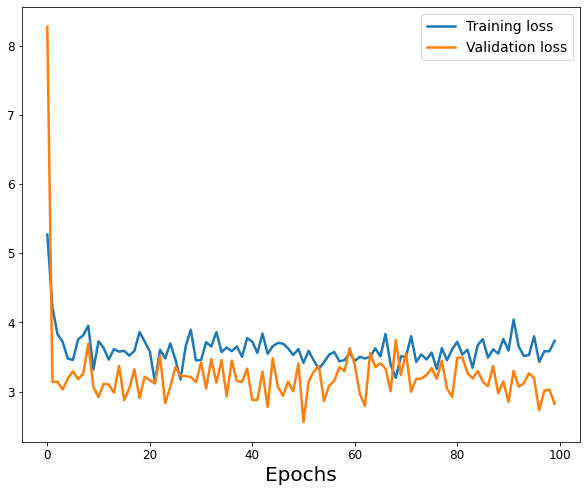

In [86]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,'-',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'-', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
plt.savefig('./../plots/loss_resnet50.png')

# Plotting training/validation accuracy

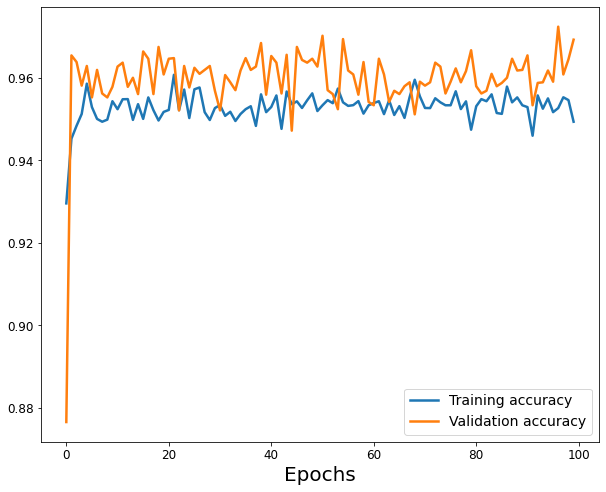

In [85]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'-', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'-', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
plt.savefig('./../plots/accuracy_resnet50.png')

# Loading model with lowest validation loss

In [38]:
res_model.load_state_dict(torch.load('./../models/res_model_pneumonia.pt'))

<All keys matched successfully>

# Testing the model

In [39]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

res_model.eval()
# iterating over test data
for data, target in tqdm(test_loader,  desc = 'Model testing: '):
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = res_model(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.278944

Test Accuracy of PNEUMONIA: 79% (185/234)
Test Accuracy of NORMAL: 96% (378/390)

Test Accuracy (Overall): 90% (563/624)


# Evaulating the model

In [40]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = res_model(data)
            target = target.long()
            _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[185.,  49.],
        [ 12., 378.]])


In [41]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.8852
Recall: 0.9692
F1 Score: 0.9253


In [55]:
?plt.xtickslabels

Object `plt.xtickslabels` not found.


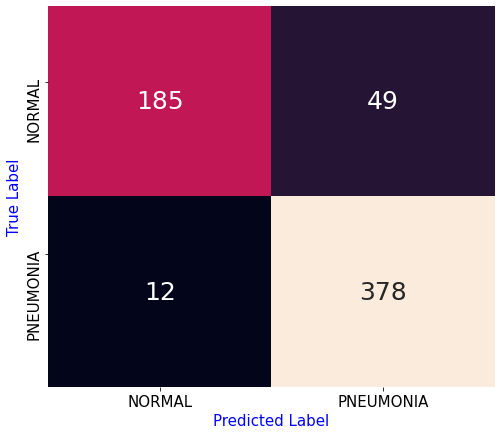

In [93]:
cm = np.array([[185,49], [12,378]])
plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 25})
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, fmt=".0f", cbar = False)
plt.xticks([0.5,1.5], xticks, fontsize = 15); plt.yticks([0.4,1.3], xticks, fontsize = 15)
plt.xlabel('Predicted Label', fontsize = 15, color = 'b')
plt.ylabel('True Label', fontsize = 15, color = 'b');

# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


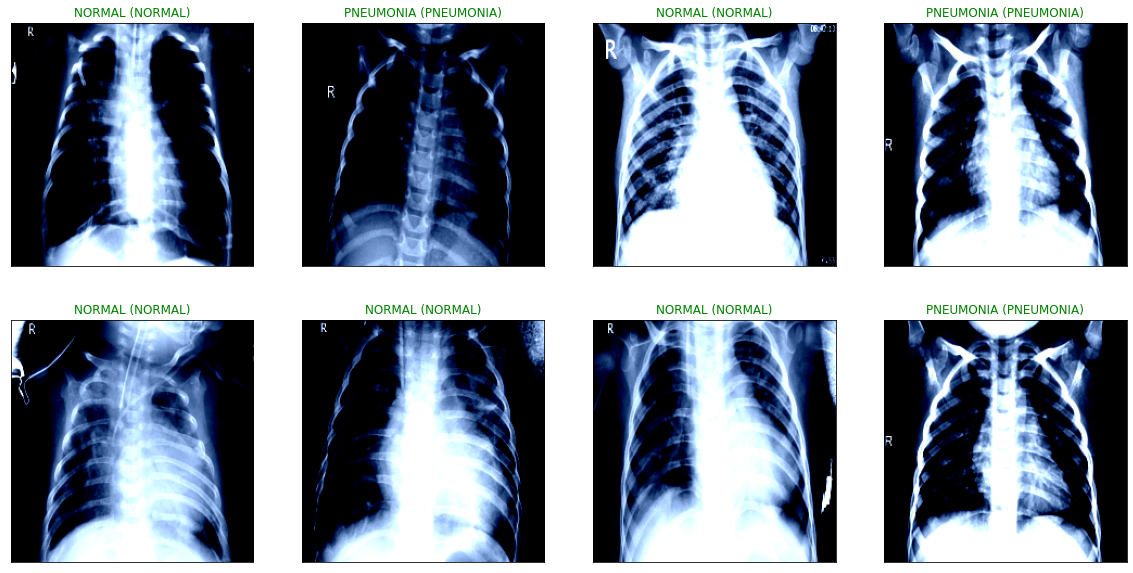

In [43]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = res_model(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))